# Number of days until the first access burst

This is a modified way to load the access data
from either journals or articles
as a Pandas dataframe
(based on the 8th notebook from the [SciELO 20 Years WG6](
  https://github.com/scieloorg/scielo20gt6
)):

In [1]:
from datetime import date
from functools import wraps
from multiprocessing.pool import ThreadPool
import os
import re
from urllib.request import urlopen

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import ujson

In [3]:
%matplotlib inline

In [4]:
def build_dataframe_from_dict(ratchet_dict, is_journal=True):
    columns = ["total", "abstract", "html", "pdf",
               "pdfsite", "toc", "issues"]
    if is_journal:
        columns.append("journal")
    dicts = {
        "total": ratchet_dict,
        "pdfsite": ratchet_dict.get("other", {}).get("pdfsite", {}),
        **{key: ratchet_dict.get(key, {})
           for key in columns if key not in ["total", "pdfsite"]},
    }
    series = []
    result = pd.DataFrame()
    for key, jdata in dicts.items():
        pairs = [(pd.Timestamp(f"{pyear[1:]}-{pmonth[1:]}-{pday[1:]}"), count)
            for pyear, ydata in jdata.items()
             if re.match(r"y\d\d\d\d", pyear)
            for pmonth, mdata in ydata.items()
             if re.match(r"m\d\d", pmonth)
            for pday, count in mdata.items()
             if re.match(r"d\d\d", pday)
        ]
        if pairs:
            dates, counts = zip(*pairs)
            series.append(pd.Series(counts, index=dates).rename(key))
    result = pd.DataFrame(series, dtype=object).reindex(columns).T
    result[result.isna()] = 0
    return pd.DataFrame(result, dtype=int).rename_axis("date")

## Part 0: Avoiding multiple downloads

As we're going to download data from the Ratchet service,
in order to freeze its results
and to avoid re-downloading the data several times,
we're going to decorate our JSON downloader function
with this file caching system:

In [5]:
def json_cache(directory):
    os.makedirs(directory, exist_ok=True)
    def decorator(func):
        @wraps(func)
        def wrapper(*args):
            fname = os.path.join(directory, "_".join(map(str, args)) + ".json")
            if os.path.exists(fname):
                with open(fname) as file_obj:
                    return ujson.load(file_obj)
            result = func(*args)
            with open(fname, "w") as file_obj:
                ujson.dump(result, file_obj)
            return result
        return wrapper
    return decorator

The JSON downloader functions for Ratchet and ArticleMeta data:

In [6]:
@json_cache("2019-08-15_ratchet")
def get_raw_access_data(entity, value):
    url = f"http://ratchet.scielo.org/api/v1/{entity}s/{value}/"
    return ujson.load(urlopen(url))

In [7]:
@json_cache("2019-08-15_articlemeta")
def get_raw_article_data(pid):
    url = "http://articlemeta.scielo.org/api/v1/article/?code=" + pid
    return ujson.load(urlopen(url))

## Part 1: How do the journals access look like?

In [8]:
def get_journal_access_df(issn):
    raw_dict_data = get_raw_access_data("journal", issn)
    return build_dataframe_from_dict(raw_dict_data)

The goal is to find if journals have a single "first burst".
It might be hard to find such a thing in a journal,
as these three examples shows
(the orange curve is the 7-day rolling median):

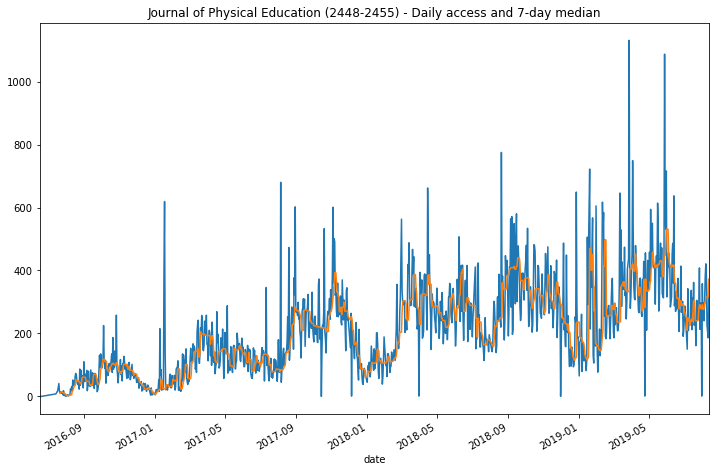

In [9]:
j_phys_educ = get_journal_access_df("2448-2455")
j_phys_educ_access = j_phys_educ[["abstract", "html", "pdf"]].T.sum()
j_phys_educ_access.plot(figsize=(12, 8))
j_phys_educ_access.rolling(window=7).median().plot(figsize=(12, 8))
plt.gca().set(title="Journal of Physical Education (2448-2455)"
                    " - Daily access and 7-day median");

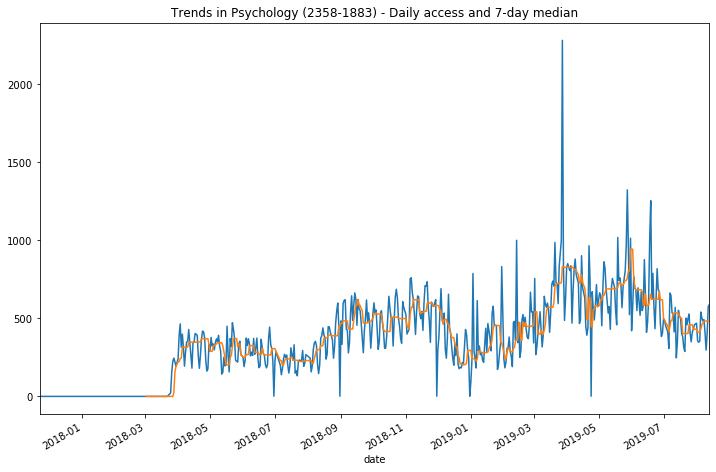

In [10]:
t_psycho = get_journal_access_df("2358-1883")
t_psycho_access = t_psycho[["abstract", "html", "pdf"]].T.sum()
t_psycho_access.plot(figsize=(12, 8))
t_psycho_access.rolling(window=7).median().plot(figsize=(12, 8))
plt.gca().set(title="Trends in Psychology (2358-1883)"
                    " - Daily access and 7-day median");

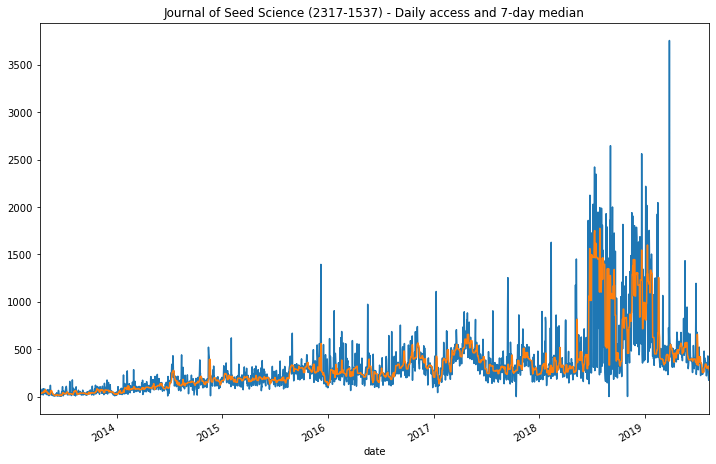

In [11]:
jss = get_journal_access_df("2317-1537")
jss_access = jss[["abstract", "html", "pdf"]].T.sum()
jss_access.plot(figsize=(12, 8));
jss_access.rolling(window=7).median().plot(figsize=(12, 8))
plt.gca().set(title="Journal of Seed Science (2317-1537)"
                    " - Daily access and 7-day median");

What should be counted as the first "burst"?
It seems unlikely that we would need to wait until late 2018
to get that information from a journal.

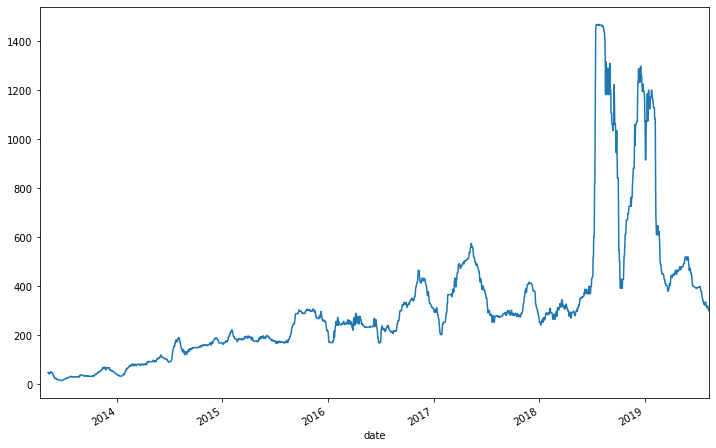

In [12]:
jss_access.rolling(window=30).median().plot(figsize=(12, 8));

There are smaller "bursts" way before,
if we see the data of a single type of accessed data (e.g. for PDFs):

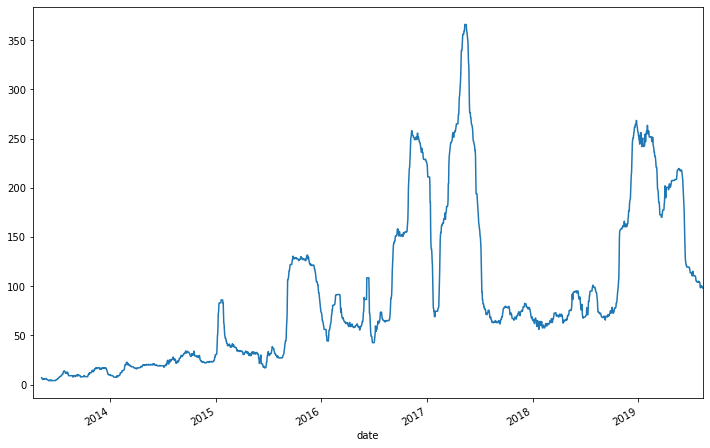

In [13]:
jss["pdf"].rolling(window=30).median().plot(figsize=(12, 8));

## Part 2: How does articles access look like? Towards what really matters!

In [14]:
def get_article_access_df(pid):
    raw_dict_data = get_raw_access_data("article", pid)
    return build_dataframe_from_dict(raw_dict_data, is_journal=False)

For active journals,
there's no reason why we would get an access curve
like an ADSR (attack/decay/sustain/release),
as it might get new publications all the time,
which have themselves an access curve shifted in time
with respect to the journal indexing date.
That said, let's see what really matters:
the access curve of a single article!
Let's see [this article](
  http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0034-71672018000200234
) from *Revista Brasileira de Enfermagem* (ISSN 0034-7167).
Again, the orange curve is the 7-day rolling median.

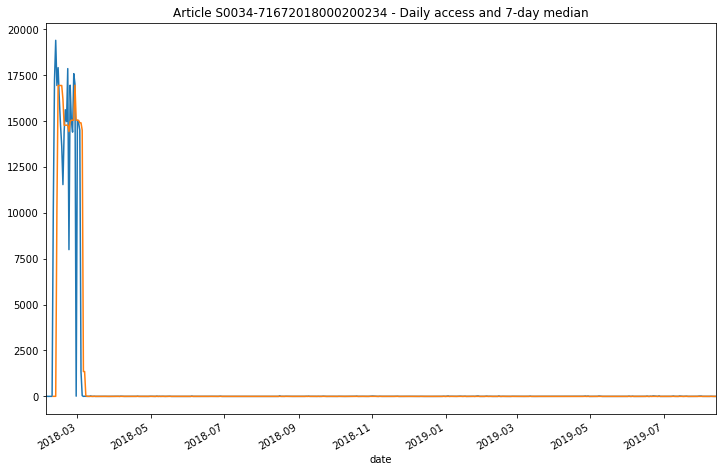

In [15]:
family_care = get_article_access_df("S0034-71672018000200234")
family_care_access = family_care[["abstract", "html", "pdf"]].T.sum()
family_care_access.plot(figsize=(12, 8))
family_care_access.rolling(window=7).median().plot(figsize=(12, 8))
plt.gca().set(title="Article S0034-71672018000200234"
                    " - Daily access and 7-day median");

That's the article access curve for the (as of 2019-08-15)
most accessed article from the SciELO Brazil collection.
We can see that
the 7-day rolling median of the daily number of accesses
drops below $10$ after the first month:

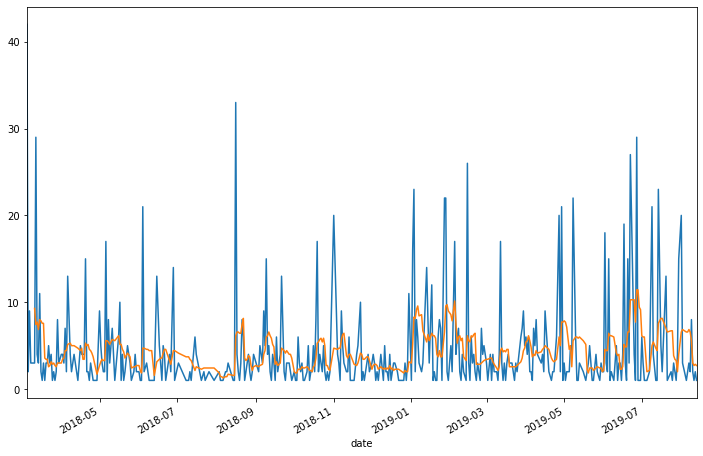

In [16]:
family_care_access.iloc[30:].plot(figsize=(12, 8));
family_care_access.iloc[30:].rolling(window=7).mean().plot(figsize=(12, 8));

Let's see [another article](
  http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0074-02762010000100002
), *Anopheles (Nyssorhynchus) atacamensis (Diptera: Culicidae),*
*a new species from Northern Chile*,
from *Memórias do Instituto Oswaldo Cruz* (ISSNs 0074-0276 and 1678-8060):

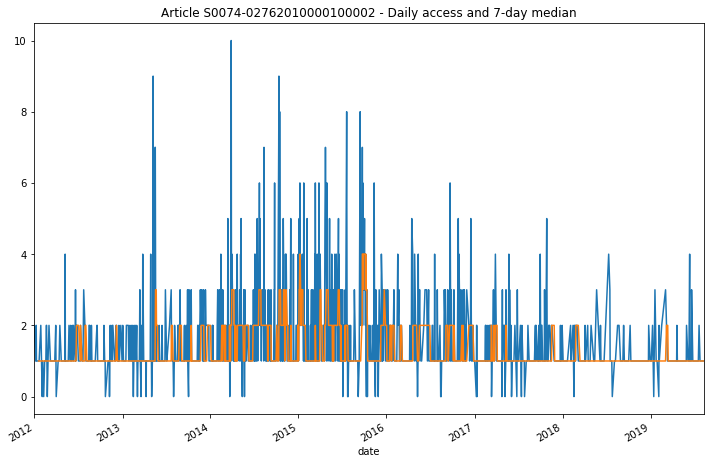

In [17]:
anopheles = get_article_access_df("S0074-02762010000100002")
anopheles_access = anopheles[["abstract", "html", "pdf"]].T.sum()
anopheles_access.plot(figsize=(12, 8))
anopheles_access.rolling(window=7).median().plot(figsize=(12, 8))
plt.gca().set(title="Article S0074-02762010000100002"
                    " - Daily access and 7-day median");

This one didn't have a leading burst,
but as it seems we don't have the access count
of when it was published.
What's the first date for which we have the access count?

In [18]:
anopheles_access.index.min()

Timestamp('2011-12-31 00:00:00')

What's the publication date for that article?

In [19]:
anopheles_dict = get_raw_article_data("S0074-02762010000100002")
print("Publication year:", anopheles_dict["publication_year"])
print("Publication date:", anopheles_dict.get("publication_date", "N/A"))
print("Processing date:", anopheles_dict["processing_date"])
print("Created at:", anopheles_dict["created_at"])
print("Issue publication date YYYYMMDD:",
      anopheles_dict["article"]["v65"][0]["_"])
print("Article processing date YYYYMMDD:",
      anopheles_dict["article"]["v91"][0]["_"])

Publication year: 2010
Publication date: N/A
Processing date: 2010-02-24
Created at: 2010-02-24
Issue publication date YYYYMMDD: 20100200
Article processing date YYYYMMDD: 20100224


Day *zero* denotes the lack of day-level information.
Anyway, the publication date is in 2010,
but the first access date information we've got
is from 2011-12-31.
That said, we probably should analyze just the PIDs
published from 2012 onwards.

Do we have this date information regarding the previous article?

In [20]:
family_care_access.index.min()

Timestamp('2018-02-03 00:00:00')

In [21]:
family_care_dict = get_raw_article_data("S0034-71672018000200234")
print("Publication year:", family_care_dict["publication_year"])
print("Publication date:", family_care_dict.get("publication_date", "N/A"))
print("Processing date:", family_care_dict["processing_date"])
print("Created at:", family_care_dict["created_at"])
print("Issue publication date YYYYMMDD:",
      family_care_dict["article"]["v65"][0]["_"])
print("Article processing date YYYYMMDD:",
      family_care_dict["article"]["v91"][0]["_"])

Publication year: 2018
Publication date: 2018-04
Processing date: 2018-02-02
Created at: 2018-02-02
Issue publication date YYYYMMDD: 20180400
Article processing date YYYYMMDD: 20180202


The first access happened on 2018-02-03,
the "creation" and "processing" steps happened the day before,
but how could the publication date be after the first access?
In which field should we trust to get this information?

Let's get a third arbitrary document:

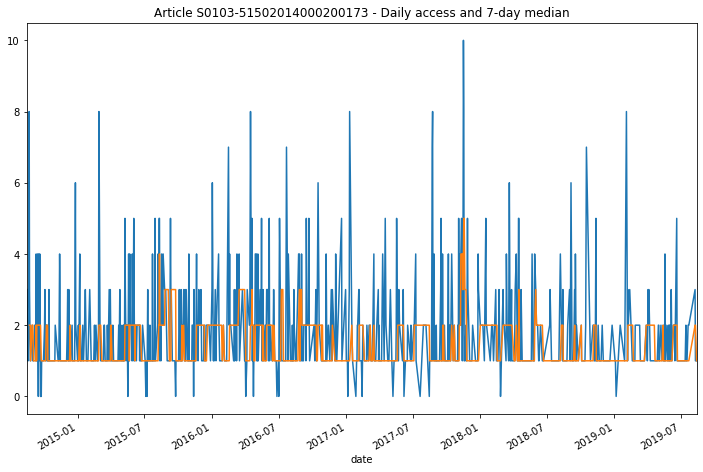

In [22]:
histomorphometrical = get_article_access_df("S0103-51502014000200173")
histomorphometrical_access = histomorphometrical[["abstract", "html", "pdf"]].T.sum()
histomorphometrical_access.plot(figsize=(12, 8))
histomorphometrical_access.rolling(window=7).median().plot(figsize=(12, 8))
plt.gca().set(title="Article S0103-51502014000200173"
                    " - Daily access and 7-day median");

In [23]:
histomorphometrical_access.index.min()

Timestamp('2014-08-15 00:00:00')

In [24]:
histomorphometrical_dict = get_raw_article_data("S0103-51502014000200173")
print("Publication year:", histomorphometrical_dict["publication_year"])
print("Publication date:", histomorphometrical_dict.get("publication_date", "N/A"))
print("Processing date:", histomorphometrical_dict["processing_date"])
print("Created at:", histomorphometrical_dict["created_at"])
print("Issue publication date YYYYMMDD:",
      histomorphometrical_dict["article"]["v65"][0]["_"])
print("Article processing date YYYYMMDD:",
      histomorphometrical_dict["article"]["v91"][0]["_"])

Publication year: 2014
Publication date: N/A
Processing date: 2015-07-23
Created at: 2014-08-11
Issue publication date YYYYMMDD: 20140600
Article processing date YYYYMMDD: 20150723


This time, the publication date happened before the first access.
But the processing date is way after the first access.
The creation date appeared 4 days before the first access.
There's no burst in this case,
should we trust in that first access date
as the day when it was actually published?

## Part 3: Collecting the access of the first N days from an external list of PIDs

One can find an external list of PIDs using something like this:

<http://articlemeta.scielo.org/api/v1/article/identifiers/?collection=scl&from=2013-01-01&to=2018-12-31>

Yet, that's paginated,
and we would need to iterate using offsets to build a PID list.
For now, let's use this external list of PIDs
whose "publication date" is from 2012 onwards:

In [25]:
with open("scl_2012_2019_pids.txt") as f:
    pids = f.read().splitlines()
len(pids)

169632

Well, it has way too many PIDs.
For now, let's get the first part of it.
Also, we will need just the first few days from each PID.

In [26]:
NUM_PIDS = 53735  # 51/161 of the PIDs, rounded up
NUM_DAYS = 45

This function should be able to get everything from these PIDs.

In [27]:
def process(pid):
    article = get_raw_article_data(pid)
    access = get_article_access_df(pid)[["abstract", "html", "pdf"]].T.sum()
    first_access_date = access.index.min().date()
    dates = [
        first_access_date,
        date.fromisoformat(article["processing_date"]),
        date.fromisoformat(article["created_at"]),
    ]
    if "publication_date" in article and \
            len(article["publication_date"]) == 10:
        dates.append(date.fromisoformat(article["publication_date"]))
    first_date = min(*dates)
    access_array = access.reindex(pd.date_range(first_date, periods=NUM_DAYS),
                                  fill_value=0).values
    return (pid, first_date, first_access_date), access_array

To build a dataframe with the number of accesses for every PID:

In [28]:
def build_dataset(pids, threads=20):
    with ThreadPool(threads) as pool:
        result = pool.map(process, pids)
    indices, arrays = zip(*result)
    return pd.DataFrame(arrays, index=indices).reset_index().rename(columns={
        "level_0": "pid",
        "level_1": "ref_date",
        "level_2": "first_access_date",
    }).set_index("pid")

From that external list,
we've got the access of the first `NUM_DAYS` days
of all these PIDs.

In [29]:
dataset = build_dataset(pids[:NUM_PIDS])
print("Total number of rows:", dataset.shape[0])
dataset.head()

Total number of rows: 53735


,ref_date,first_access_date,0,1,2,3,4,5,6,7,...,35,36,37,38,39,40,41,42,43,44
pid,,,,,,,,,,,,,,,,,,,,,
S0102-86502013000400010,2013-04-02,2013-04-09,0,0,0,0,0,0,0,1,...,4,4,0,0,0,1,3,1,1,3
S0034-75902015000100038,2015-02-25,2015-02-28,0,0,0,1,9,1,2,8,...,0,2,1,0,2,1,2,0,2,0
S0102-09352017000100039,2017-03-20,2017-03-23,0,0,0,1,10,3,3,3,...,9,4,4,3,7,0,5,0,0,4
S0100-204X2018000500641,2018-08-15,2018-08-18,0,0,0,5,2,2,1,2,...,1,0,0,3,0,0,1,0,2,0
S0102-695X2012000400015,2012-06-27,2012-07-03,0,0,0,0,0,0,5,0,...,0,1,0,0,0,1,2,0,1,0


## Part 4: Collecting some statistics from the access data

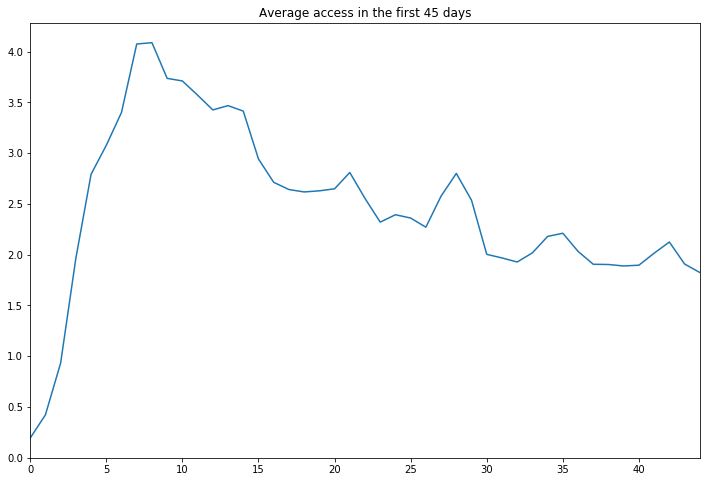

In [30]:
dataset.mean().plot(
    title=f"Average access in the first {NUM_DAYS} days",
    figsize=(12, 8),
);

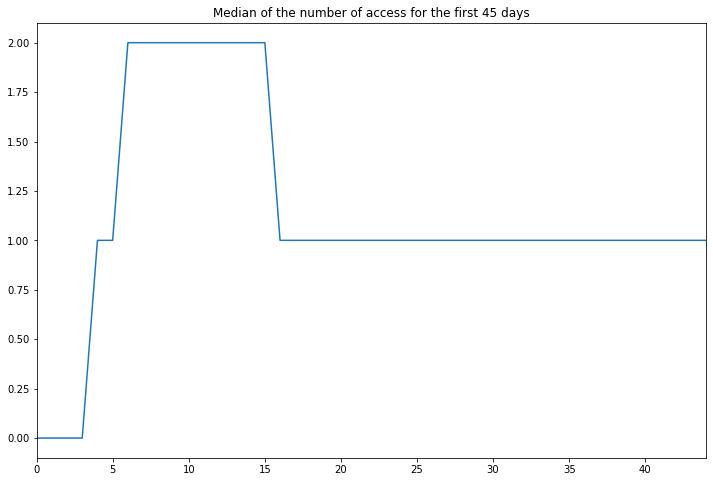

In [31]:
dataset.median().plot(
    title=f"Median of the number of access for the first {NUM_DAYS} days",
    figsize=(12, 8),
);

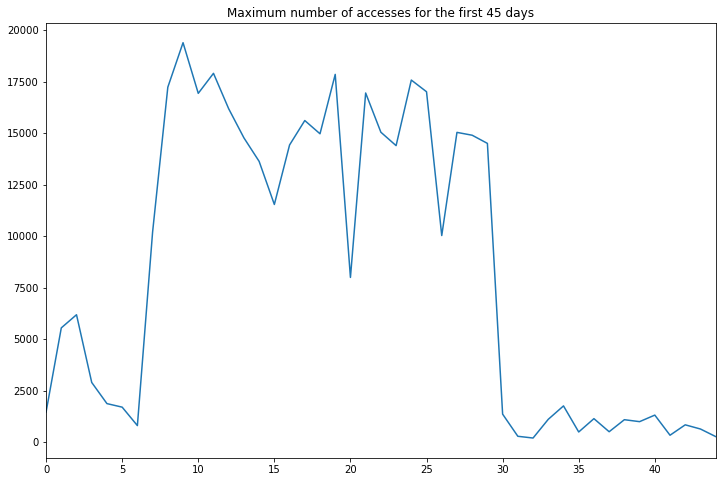

In [32]:
dataset.max().drop(["ref_date", "first_access_date"]).plot(
    title=f"Maximum number of accesses for the first {NUM_DAYS} days",
    figsize=(12, 8),
);